### Imports

In [22]:
import pandas as pd
import numpy as np

from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

import yfinance as yf
yf.pdr_override()

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Plotting - Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

### Get Data

In [23]:
# Parameters
start_date = '2017-01-01'
end_date = '2024-01-01'

etf_data_filename = 'data/raw_etf_data.csv'
coint_data_filename = 'data/raw_coint_pairs_data.csv'

is_loaded_etf_data = True
is_loaded_coint_paris_data = False


In [24]:
# Get Data

if not is_loaded_etf_data:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols['ETF']==True) &(symbols['Market Category']== "G")]
    symbols = symbols.index.tolist()    
    data = DataReader(symbols, start_date, end_date)['Adj Close']
    data.to_csv(etf_data_filename)

[*********************100%%**********************]  594 of 594 completed


5 Failed downloads:
['BRRR', 'MEMS', 'SKRE', 'DYFI']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1704085200")
['MCHS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [33]:
# Load Data and Refactor

loaded_etf_data = pd.read_csv(etf_data_filename)
loaded_etf_data.dropna(inplace=True,axis=1)
loaded_etf_data = loaded_etf_data.set_index('Date')

print(f"null values {loaded_etf_data.isnull().values.any()}")
print(f"shape {loaded_etf_data.shape}")
loaded_etf_data.head()


null values False
shape (1760, 259)


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,ASET,BBH,BFIT,BIB,BIS,BJK,BND,BNDX,BOTZ,BSCO,BSCP,BSCQ,BSJO,BTEC,CARZ,CATH,CDC,CDL,CFA,CFO,CIBR,CID,CIL,CIZ,CNCR,COMT,CSA,CSB,CSF,CXSE,...,SHY,SKOR,SKYY,SLQD,SMCP,SMH,SNSR,SOCL,SOXX,SQQQ,SRET,TDIV,TLT,TQQQ,TUR,UAE,USIG,VCIT,VCLT,VCSH,VGIT,VGLT,VGSH,VIGI,VMBS,VNQI,VONE,VONG,VONV,VRIG,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,38.266670,48.610233,52.050148,33.607410,14.51346,14.884952,40.685699,23.451803,8.660433,20.295172,21.303381,106.829826,13.470634,41.357182,129.456375,30.176689,66.892021,44.639957,14.625056,16.905054,16.627554,15.725823,17.669598,22.779987,30.438057,24.833710,33.102997,32.182713,36.843380,35.926941,18.881823,22.768400,27.177433,23.908512,19.619465,17.381001,37.730549,32.489754,36.498291,22.327806,...,76.100243,40.458305,33.777138,42.550678,21.576851,33.198338,14.858704,21.286957,113.672394,4593.479004,25.211178,25.356287,101.692680,5.300240,25.171286,12.884158,43.903130,68.229019,67.714592,66.870262,55.434132,61.891056,53.777287,44.191765,44.459084,37.829479,92.172440,25.288885,41.971375,20.666321,92.506126,39.783001,106.655449,49.565155,91.095390,55.973526,37.490696,42.702923,47.666115,25.109816
2017-01-04 00:00:00,38.925316,49.092220,52.495323,33.980915,14.51346,14.918928,40.903091,23.797686,8.782168,20.358397,21.303381,108.745140,13.470634,43.494968,122.869957,30.540155,66.941673,44.664722,14.838137,16.921616,16.613560,15.735639,17.733629,23.716015,31.150566,25.008823,33.378620,32.385490,37.197308,36.325356,19.132294,22.984631,27.511017,24.042774,20.297344,17.559242,38.524242,32.834843,37.009037,22.717245,...,76.118294,40.450237,34.252876,42.567642,22.205772,33.304745,14.990781,21.647917,113.987320,4513.969727,25.506962,25.458258,102.083611,5.390536,25.211351,12.733026,43.999538,68.452126,67.835648,66.920876,55.451477,62.125618,53.812744,44.625179,44.442085,38.330223,92.858833,25.508404,42.265354,20.705164,93.569305,39.799179,108.894730,50.308540,92.473640,56.196545,37.904469,43.135925,48.091225,25.436157
2017-01-05 00:00:00,39.342770,49.784519,52.696087,34.271423,14.51346,14.915843,41.407417,23.393667,8.847669,20.407566,21.725191,109.464600,13.470634,43.784672,122.176636,30.903624,67.281075,44.631702,14.867193,17.004448,16.689285,15.799496,17.775143,23.676603,31.202705,24.880892,33.192478,32.202614,37.024876,36.112846,19.276800,22.984631,27.511017,24.285292,20.363586,17.732388,37.938755,32.425079,36.489319,22.717245,...,76.172409,40.539101,34.398502,42.593086,22.408962,33.110443,14.971914,22.555197,113.014740,4445.302734,25.715746,25.483751,103.681625,5.486120,25.107170,12.982395,44.228462,68.723122,68.607086,67.038971,55.668106,63.021969,53.857059,45.191959,44.654385,38.785450,92.760811,25.552765,42.099182,20.688644,93.399551,39.847736,108.056175,49.806862,91.227074,56.556301,38.188423,43.553982,48.055801,25.520077
2017-01-06 00:00:00,39.212902,49.539143,52.704819,34.130318,14.51346,14.903485,41.233505,23.393667,8.932882,20.428638,21.725191,110.446564,13.470634,44.414013,120.481873,30.770641,67.016197,44.516174,14.886562,16.913330,16.652245,15.729913,17.739962,23.676603,31.002853,25.142204,33.254803,32.237595,37.142834,36.174847,19.421303,23.083378,27.752848,24.000811,20.554157,17.681467,37.785107,32.312901,36.247360,22.717245,...,76.109291,40.506794,34.631519,42.567642,22.054832,33.281616,14.934175,22.233257,113.913193,4322.424805,25.628761,25.500744,102.729622,5.625226,24.858744,12.854687,44.055756,68.380455,68.130615,66.920876,55.520786,62.427227,53.821621,44.958569,44.560982,38.747520,93.144081,25.692890,42.167366,20.691116,93.640793,39.783001,107.503502,49.597069,90.735504,56.397995,38.107292,43.322559,48.055801,25.566698
2017-01-09 00:00:00,39.352051,49.582970,52.582607,34.080517,14.51346,14.866420,41.346546,22.900957,8.875491,20.442692,21.725191,112.118813,13.713396,45.642746,117.053856,30.788372,67.181732,44.631702,14.847821,17.004448,

### Feature Engineering

In [41]:
# We will be working with Returns and Volatility

df_featured = pd.DataFrame(loaded_etf_data.pct_change().mean()*252,columns=['Returns'])
df_featured['Volatility'] =loaded_etf_data.pct_change().std()*np.sqrt(252)
df_featured.head()

,Returns,Volatility
AADR,0.080586,0.224496
AAXJ,0.066470,0.206656
ACWI,0.112538,0.180856
ACWX,0.076196,0.179948
AGNG,0.112798,0.180827


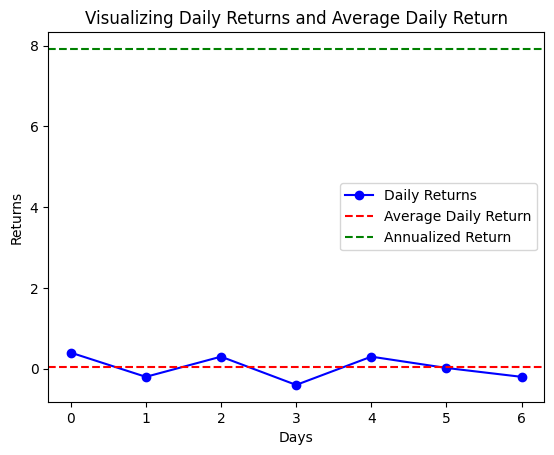

In [39]:
### To help understand the logic above...
returns_data = pd.Series([0.4, -0.2, 0.3, -0.4,0.3,0.02,-0.2])
average_daily_return = returns_data.mean()
annualized_return = average_daily_return * 252

# Plot daily returns
plt.plot(returns_data, marker='o', linestyle='-', color='b', label='Daily Returns')

# Plot average daily return as a horizontal line
plt.axhline(y=average_daily_return, linestyle='--', color='r', label='Average Daily Return')

# Plot annualized return as a horizontal line
plt.axhline(y=annualized_return, linestyle='--', color='g', label='Annualized Return')

# Labeling
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.title('Visualizing Daily Returns and Average Daily Return')
plt.show()

In [44]:
# Scale Features

scaler = StandardScaler()
scaler = scaler.fit_transform(df_featured)

df_scaled = pd.DataFrame(scaler,columns=df_featured.columns,index=df_featured.index)
df_scaled.head()

,Returns,Volatility
AADR,-0.100599,0.223924
AAXJ,-0.288638,0.035570
ACWI,0.325056,-0.236820
ACWX,-0.159077,-0.246399
AGNG,0.328517,-0.237123


### K-Means Clustering

In [63]:
# Optimum number of clusters ?

X = df_scaled.copy()
K = range(1,15)
distortions = []

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

kl=KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kl.elbow

print(f"Optimum number of clusters {c}")

c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Optimum number of clusters 5


In [64]:
# Fit The Model

k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)


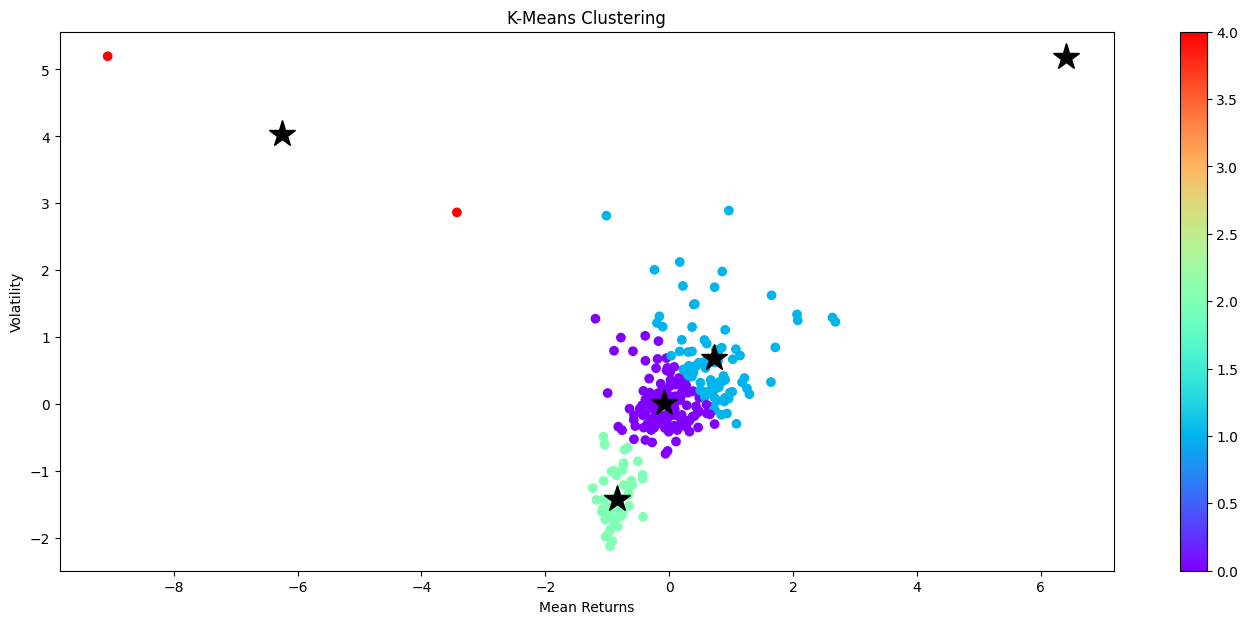

In [65]:
# Plotting

centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1],c=k_means.labels_,cmap="rainbow",label=X.index)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Mean Returns')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'k*',markersize=20)
plt.show()


In [66]:
# Return Series

clustered_series = pd.Series(index=X.index,data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index,data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]


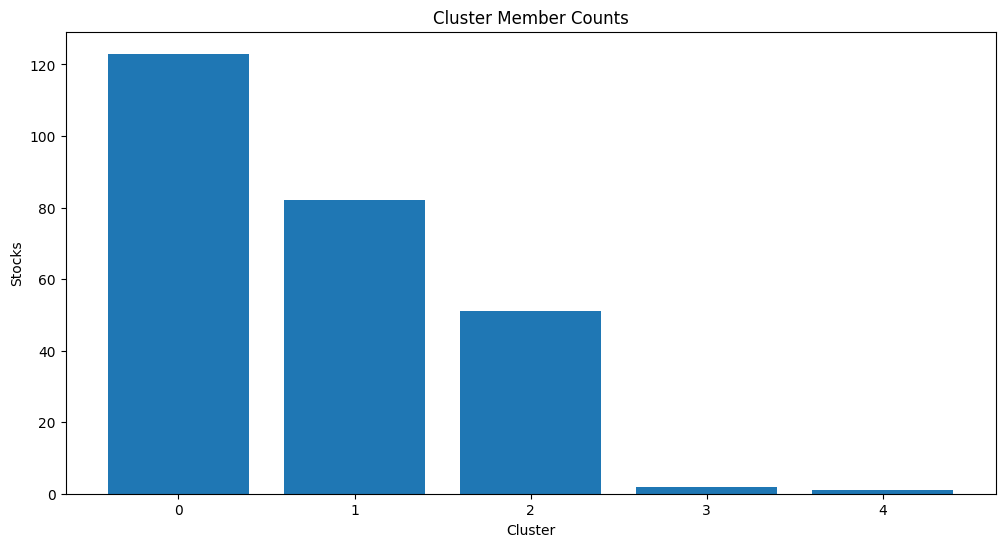

In [67]:
# Plotting

plt.figure(figsize=(12,6))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.xlabel('Cluster')
plt.ylabel('Stocks')
plt.title('Cluster Member Counts')
plt.show()

Clean stocks number 256
Original stocks number 259


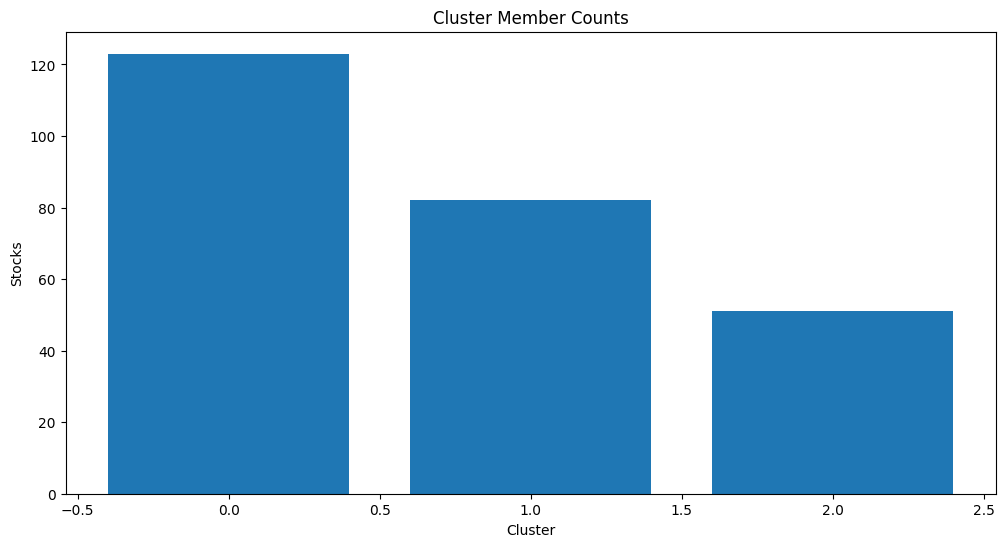

In [69]:
# Remove Outliers

clusters_clean = clustered_series[clustered_series < 3]

print(f"Clean stocks number {len(clusters_clean)}")
print(f"Original stocks number {len(clustered_series)}")

plt.figure(figsize=(12,6))
plt.bar(range(len(clusters_clean.value_counts())),clusters_clean.value_counts())
plt.xlabel('Cluster')
plt.ylabel('Stocks')
plt.title('Cluster Member Counts')
plt.show()